<a href="https://colab.research.google.com/github/a-matson/DST_ASS1/blob/main/report.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Introduction

In this project, we will explore different classification techniques as applied to the Diagnostic Wisconsin Breast Cancer Database, found on the UCI ML repository here: https://archive.ics.uci.edu/dataset/17/breast+cancer+wisconsin+diagnostic.

## Dataset

The dataset was first introduced in Street et al. [1] in 1992. Fine needle aspirations were taken from 569 subjects with (either malignant or benign) breast tumours and captured as an image. Using interactive image processing techniques, the boundaries of all cell nuclei in the image are identified. For each nucleus, the following ten features are captured:

1. Radius
2. Perimeter
3. Area
4. Compactness
5. Smoothness
6. Concavity
7. Concave Points
8. Symmetry
9. Fractal Dimension
10. Texture

(See [1] for exact definitions of these features.)

Then, for each image, the three statistics of each feature are computed: the mean value, largest (or 'worst') value and standard error.

This yields a database of 569 30-dimensional points, which are labelled as either benign or malignant; the goal is to classify them as such.

## Techniques

After performing exploratory data analysis, we will investigate four different binary classification methods as applied to the dataset: logistic regression; support vector machines; decision trees and random forests; and neural networks.

We note that in [1] the authors were able to achieve a accuracy of 97.0% using a single-plane classifier and performing ten-fold cross-validation. As they describe in their method, shifting the decision boundary can lead to 100% specificity or sensitivity.

# Performance metrics

While accuracy is a decent measure of a classifier's performance, we found that more commonly used metrics in medical domains are sensitivity (true positive rate) and specificity (true negative rate); this is discussed in [1]. In particular, we chose to prioritise sensitivity as our key performance metric, because the higher the sensitivity, the fewer the false positives predicted. Note that we see this classification task as a diagnostic tool. We want to penalise false negatives as much as possible, as missing a cancer diagnosis is potentially fatal, whereas there is less risk for mistakenly diagnosing someone with cancer when they do not have it.

Thus, our primary goal will be maximising sensitivity values of our models, but we will also report specificity, ROC curves, accuracy and more.



# Imports and setting up dataset

Install the UCI ML repository Python library, from which we will retrieve the dataset.

In [1]:
!pip install ucimlrepo

Import other necessary libraries.

In [2]:
import sklearn as sklearn
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import random

from sklearn.model_selection import train_test_split, KFold, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, roc_auc_score
from sklearn.ensemble import RandomForestClassifier
import sklearn.tree

import matplotlib.gridspec as gridspec # subplots
%matplotlib inline

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset

Load the Wisconsin Breast Cancer Database.

In [3]:
from ucimlrepo import fetch_ucirepo

# fetch dataset
breast_cancer_wisconsin_diagnostic = fetch_ucirepo(id=17)

# data (as pandas dataframes)
X = breast_cancer_wisconsin_diagnostic.data.features
y = breast_cancer_wisconsin_diagnostic.data.targets

y['Diagnosis'] = y['Diagnosis'].map({'M':0, 'B':1})

# metadata
#print(breast_cancer_wisconsin_diagnostic.metadata)

# variable information
#print(breast_cancer_wisconsin_diagnostic.variables)

<ipython-input-3-411e26e520e5>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  y['Diagnosis'] = y['Diagnosis'].map({'M':0, 'B':1})


Rename the columns to have meaningful names.

In [4]:
column_name_mapping = {
    "radius1": "radius_mean",
    "texture1": "texture_mean",
    "perimeter1": "perimeter_mean",
    "area1": "area_mean",
    "smoothness1": "smoothness_mean",
    "compactness1": "compactness_mean",
    "concavity1": "concavity_mean",
    "concave_points1": "concave_points_mean",
    "symmetry1": "symmetry_mean",
    "fractal_dimension1": "fractal_dimension_mean",
    "radius2": "radius_se",
    "texture2": "texture_se",
    "perimeter2": "perimeter_se",
    "area2": "area_se",
    "smoothness2": "smoothness_se",
    "compactness2": "compactness_se",
    "concavity2": "concavity_se",
    "concave_points2": "concave_points_se",
    "symmetry2": "symmetry_se",
    "fractal_dimension2": "fractal_dimension_se",
    "radius3": "radius_worst",
    "texture3": "texture_worst",
    "perimeter3": "perimeter_worst",
    "area3": "area_worst",
    "smoothness3": "smoothness_worst",
    "compactness3": "compactness_worst",
    "concavity3": "concavity_worst",
    "concave_points3": "concave_points_worst",
    "symmetry3": "symmetry_worst",
    "fractal_dimension3": "fractal_dimension_worst",
}

# Rename columns

X = X.rename(columns=column_name_mapping)
X.columns

Index(['radius_mean', 'texture_mean', 'perimeter_mean', 'area_mean',
       'smoothness_mean', 'compactness_mean', 'concavity_mean',
       'concave_points_mean', 'symmetry_mean', 'fractal_dimension_mean',
       'radius_se', 'texture_se', 'perimeter_se', 'area_se', 'smoothness_se',
       'compactness_se', 'concavity_se', 'concave_points_se', 'symmetry_se',
       'fractal_dimension_se', 'radius_worst', 'texture_worst',
       'perimeter_worst', 'area_worst', 'smoothness_worst',
       'compactness_worst', 'concavity_worst', 'concave_points_worst',
       'symmetry_worst', 'fractal_dimension_worst'],
      dtype='object')

In [5]:
df = pd.concat([X , y] , axis = 1)
df

,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave_points_mean,symmetry_mean,fractal_dimension_mean,...,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave_points_worst,symmetry_worst,fractal_dimension_worst,Diagnosis
0,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.30010,0.14710,0.2419,0.07871,...,17.33,184.60,2019.0,0.16220,0.66560,0.7119,0.2654,0.4601,0.11890,0
1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.08690,0.07017,0.1812,0.05667,...,23.41,158.80,1956.0,0.12380,0.18660,0.2416,0.1860,0.2750,0.08902,0
2,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.19740,0.12790,0.2069,0.05999,...,25.53,152.50,1709.0,0.14440,0.42450,0.4504,0.2430,0.3613,0.08758,0
3,11.42,20.38,77.58,386.1,0.14250,0.28390,0.24140,0.10520,0.2597,0.09744,...,26.50,98.87,567.7,0.20980,0.86630,0.6869,0.2575,0.6638,0.17300,0
4,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.19800,0.10430,0.1809,0.05883,...,16.67,152.20,1575.0,0.13740,0.20500,0.4000,0.1625,0.2364,0.07678,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
564,21.56,22.39,142.00,1479.0,0.11100,0.11590,0.24390,0.13890,0.1726,0.05623,...,26.40,166.10,2027.0,0.14100,0.21130,0.4107,0.2216,0.2060,0.07115,0
565,20.13,28.25,131.20,1261.0,0.09780,0.10340,0.14400,0.09791,0.1752,0.05533,...,38.25,155.00,1731.0,0.11660,0.19220,0.3215,0.1628,0.2572,0.06637,0
566,16.60,28.08,108.30,858.1,0.08455,0.10230,0.09251,0.05302,0.1590,0.05648,...,34.12,126.70,1124.0,0.11390,0.30940,0.3403,0.1418,0.2218,0.07820,0
567,20.60,29.33,140.10,1265.0,0.11780,0.27700,0.35140,0.15200,0.2397,0.07016,...,39.42,184.60,1821.0,0.16500,0.86810,0.9387,0.2650,0.4087,0.12400,0


#Exploratory Data Analysis

In [6]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 569 entries, 0 to 568
Data columns (total 30 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   radius_mean              569 non-null    float64
 1   texture_mean             569 non-null    float64
 2   perimeter_mean           569 non-null    float64
 3   area_mean                569 non-null    float64
 4   smoothness_mean          569 non-null    float64
 5   compactness_mean         569 non-null    float64
 6   concavity_mean           569 non-null    float64
 7   concave_points_mean      569 non-null    float64
 8   symmetry_mean            569 non-null    float64
 9   fractal_dimension_mean   569 non-null    float64
 10  radius_se                569 non-null    float64
 11  texture_se               569 non-null    float64
 12  perimeter_se             569 non-null    float64
 13  area_se                  569 non-null    float64
 14  smoothness_se            5

From inspection we see that the data has no null values and is all of type float64. Therefore we do not need to edit any feature types or remove any incomplete datapoints.

We can also check the rough distributions of the features.

In [7]:
X.describe()

,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave_points_mean,symmetry_mean,fractal_dimension_mean,...,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave_points_worst,symmetry_worst,fractal_dimension_worst
count,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,...,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000
mean,14.127292,19.289649,91.969033,654.889104,0.096360,0.104341,0.088799,0.048919,0.181162,0.062798,...,16.269190,25.677223,107.261213,880.583128,0.132369,0.254265,0.272188,0.114606,0.290076,0.083946
std,3.524049,4.301036,24.298981,351.914129,0.014064,0.052813,0.079720,0.038803,0.027414,0.007060,...,4.833242,6.146258,33.602542,569.356993,0.022832,0.157336,0.208624,0.065732,0.061867,0.018061
min,6.981000,9.710000,43.790000,143.500000,0.052630,0.019380,0.000000,0.000000,0.106000,0.049960,...,7.930000,12.020000,50.410000,185.200000,0.071170,0.027290,0.000000,0.000000,0.156500,0.055040
25%,11.700000,16.170000,75.170000,420.300000,0.086370,0.064920,0.029560,0.020310,0.161900,0.057700,...,13.010000,21.080000,84.110000,515.300000,0.116600,0.147200,0.114500,0.064930,0.250400,0.071460
50%,13.370000,18.840000,86.240000,551.100000,0.095870,0.092630,0.061540,0.033500,0.179200,0.061540,...,14.970000,25.410000,97.660000,686.500000,0.131300,0.211900,0.226700,0.099930,0.282200,0.080040
75%,15.780000,21.800000,104.100000,782.700000,0.105300,0.130400,0.130700,0.074000,0.195700,0.066120,...,18.790000,29.720000,125.400000,1084.000000,0.146000,0.339100,0.382900,0.161400,0.317900,0.092080
max,28.110000,39.280000,188.500000,2501.000000,0.163400,0.345400,0.426800,0.201200,0.304000,0.097440,...,36.040000,49.540000,251.200000,4254.000000,0.222600,1.058000,1.252000,0.291000,0.663800,0.207500


In [8]:
y.describe()

,Diagnosis
count,569.000000
mean,0.627417
std,0.483918
min,0.000000
25%,0.000000
50%,1.000000
75%,1.000000
max,1.000000


As can be seen above approximately $63\%$ of the diagnoses are benign. Thus, the binary classes are (roughly) evenly split, which is favourable since all of the classification methods we use can be sensitive to class imbalances.

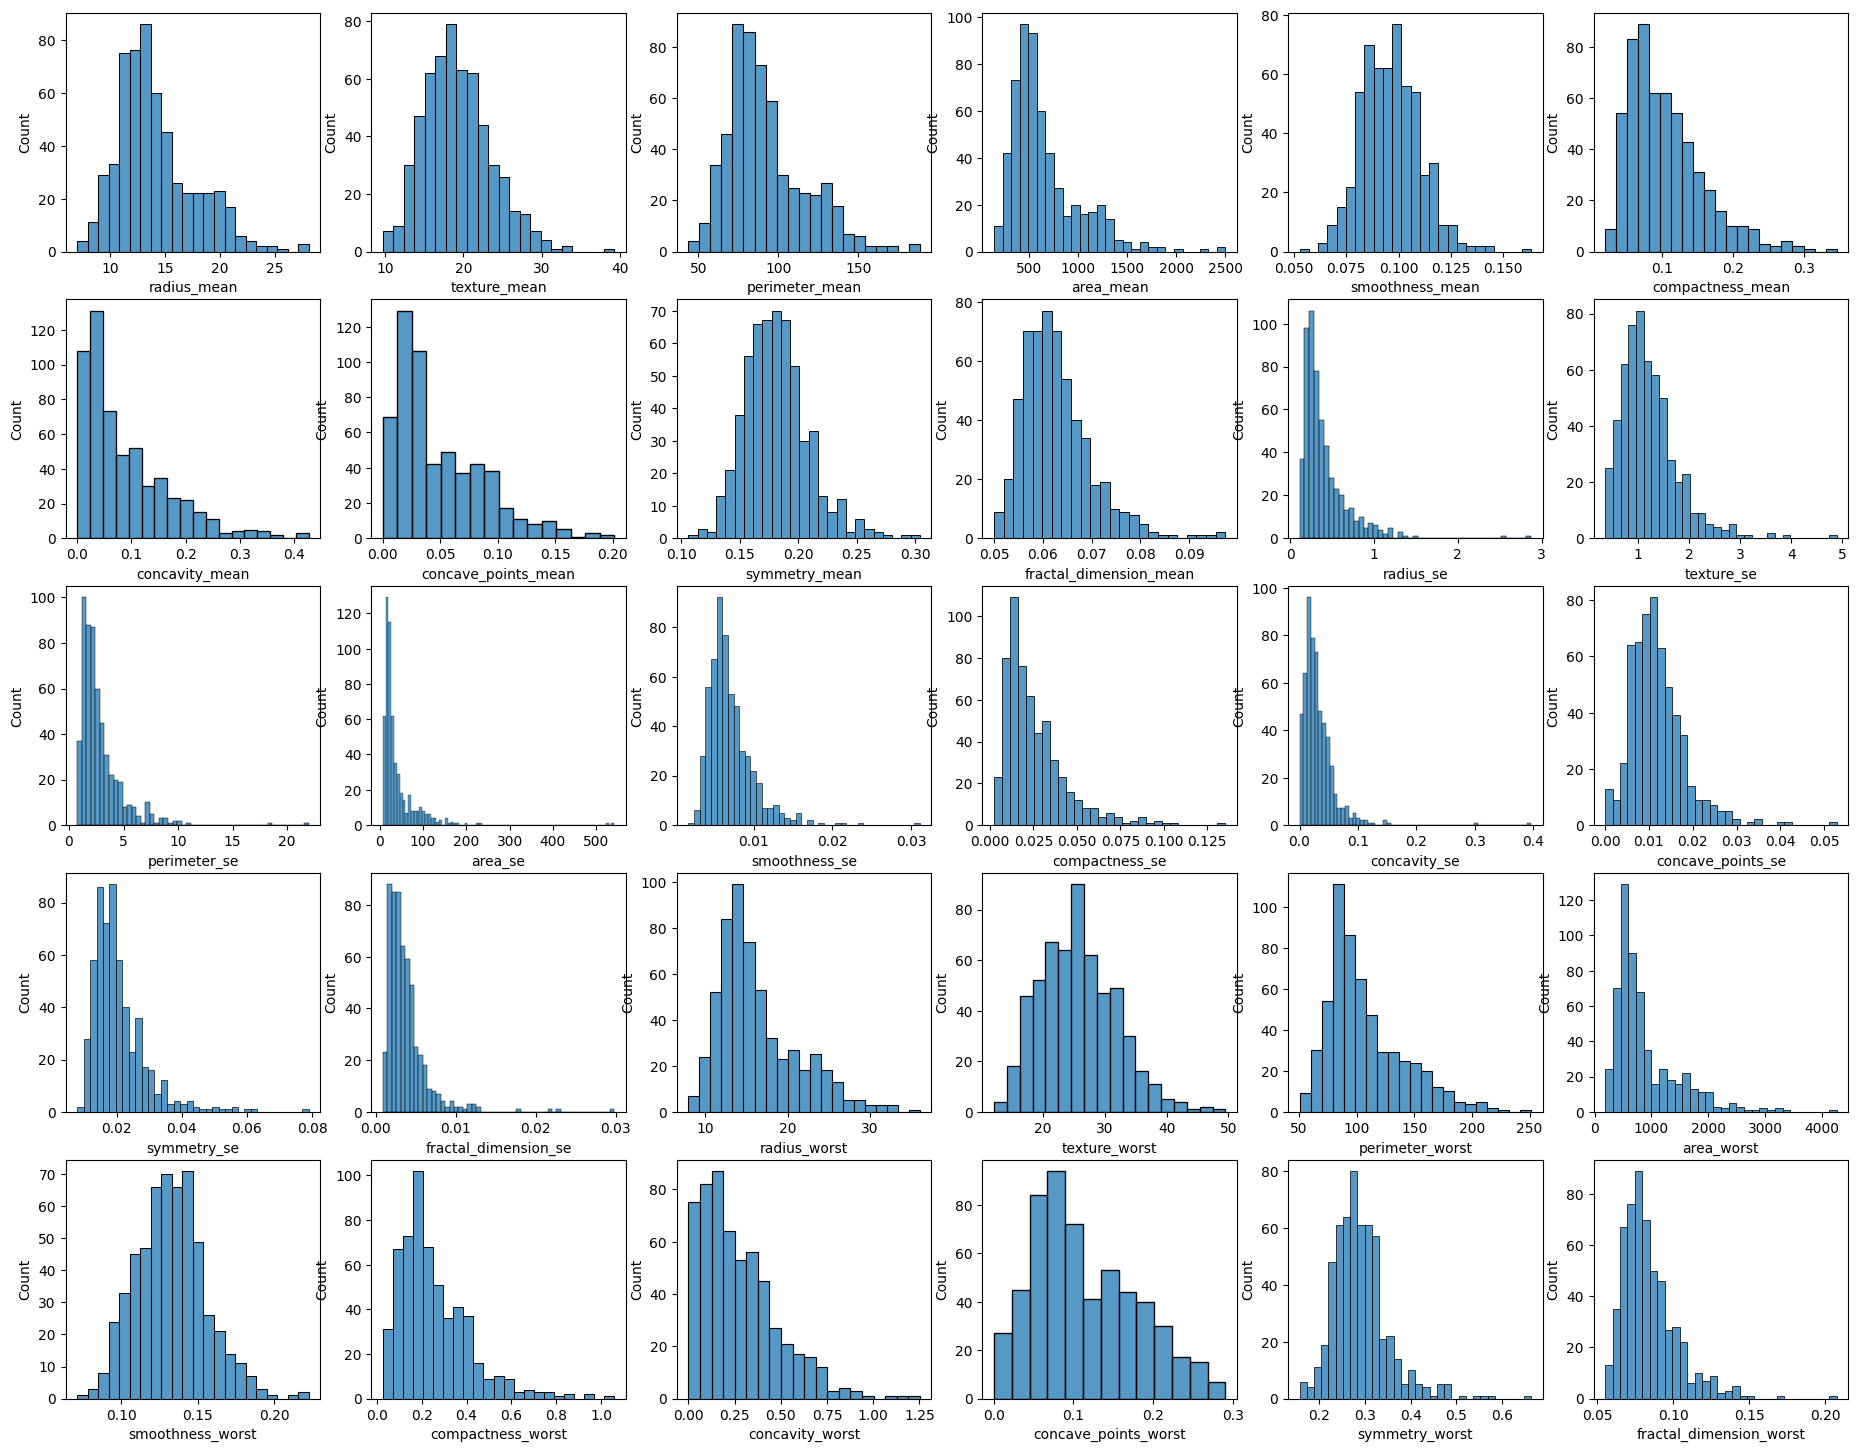

In [9]:
## And we can quickly visualize these summaries with histograms

fig, axes = plt.subplots(nrows=5, ncols=6, figsize=(23, 18))

axes = axes.flatten()

for i, col in enumerate(X.columns):
    sns.histplot(x=X[col], ax=axes[i])

for i in range(len(X.columns), len(axes)):
    fig.delaxes(axes[i])

plt.show()

By inspection of the feature distributions we can see that the features live on very different scales with widely different associated variances. Indeed both logistic regression, neural networks and SVM are rely on the data being scaled. This suggests that an important stage in preprocessing the data would be to scale/normalise the data using the sklearn StandardScaler function. This transforms the data by removing the mean and scaling for unit variance.

It is interesting to note some features (for example symmetry_mean) almost follow a normal distribution whereas others (for example area_mean) seem to follow different distributions (something like a Poisson).

In features such as concavity_se, there appear to be rather large outliers. This could have a detrimental impact on some models, for example models which use a distance metric of mean-squared error (MSE), since these are sensitive to outliers.

It can be useful to check if there are any duplicate data points as these can hold more weight in the model creation than data which has not been duplicated.

In [10]:
## We can also check if there is any duplicated data
X.duplicated().sum()

0

As we see, there is no issue here.

Let us look at the correlation matrix across all the features combined with the target variable.

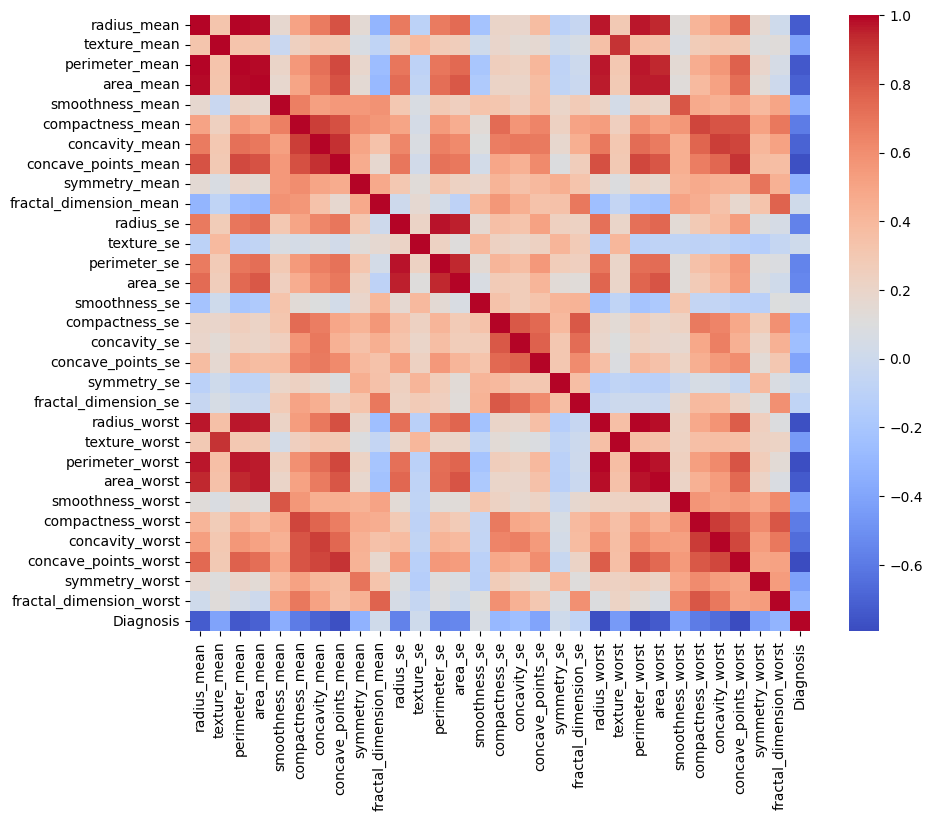

In [11]:
data = pd.concat([X, y], axis=1)
corr = data.corr()
plt.figure(figsize=(10, 8))
sns.heatmap(corr, annot=False, cmap='coolwarm', cbar=True)
plt.show()

By looking at the 'Diagnosis' column, we see that nearly all of the input features are somewhat strongly (negatively) correlated to the diagnosis. This is encouraging, as it suggests that the data features will lend themselves well to this classification of diagnosis.

Moreover, we see that a lot of the features are somewhat positively correlated to each other. This is to be expected for a few reasons. Firstly, one would expect that for a given original feature, that their mean, standard error and worst values would be correlated since they are derived from the same sample of features. Secondly, the individual features have been gathered from the same breast tumour cell nuclei, and for example we expect some connection between features like radius, perimeter and area, as they are all measures of the size of these nuclei.


We would like to explore the relationship between two features which are highly correlated: radius_mean and perimeter_mean are almost perfectly correlated with a correlation of 0.997855.

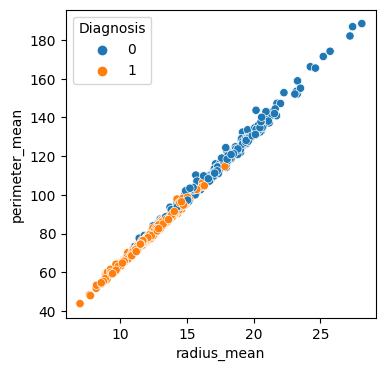

In [12]:
# Scatter Plot - Attribute radius_mean and Attribute perimeter_mean

plt.figure(figsize=(4,4))
sns.scatterplot(x=X['radius_mean'], y=X['perimeter_mean'], hue=data['Diagnosis'])
plt.show()

As expected, there is an almost perfect correlation between the two features. This of course makes sense as perimeter and radius are close to being scalar multiples of each other (not exactly, however, as the cell nuclei are not necessarily circular as shown in [1]). It also appears as there is a divide between the different diagnoses when the magnitude of the two variables is small or large relatively. This suggests that these variables can hold predictive power.

We repeat this with other variables with varying correlations.

<Figure size 1500x1500 with 0 Axes>

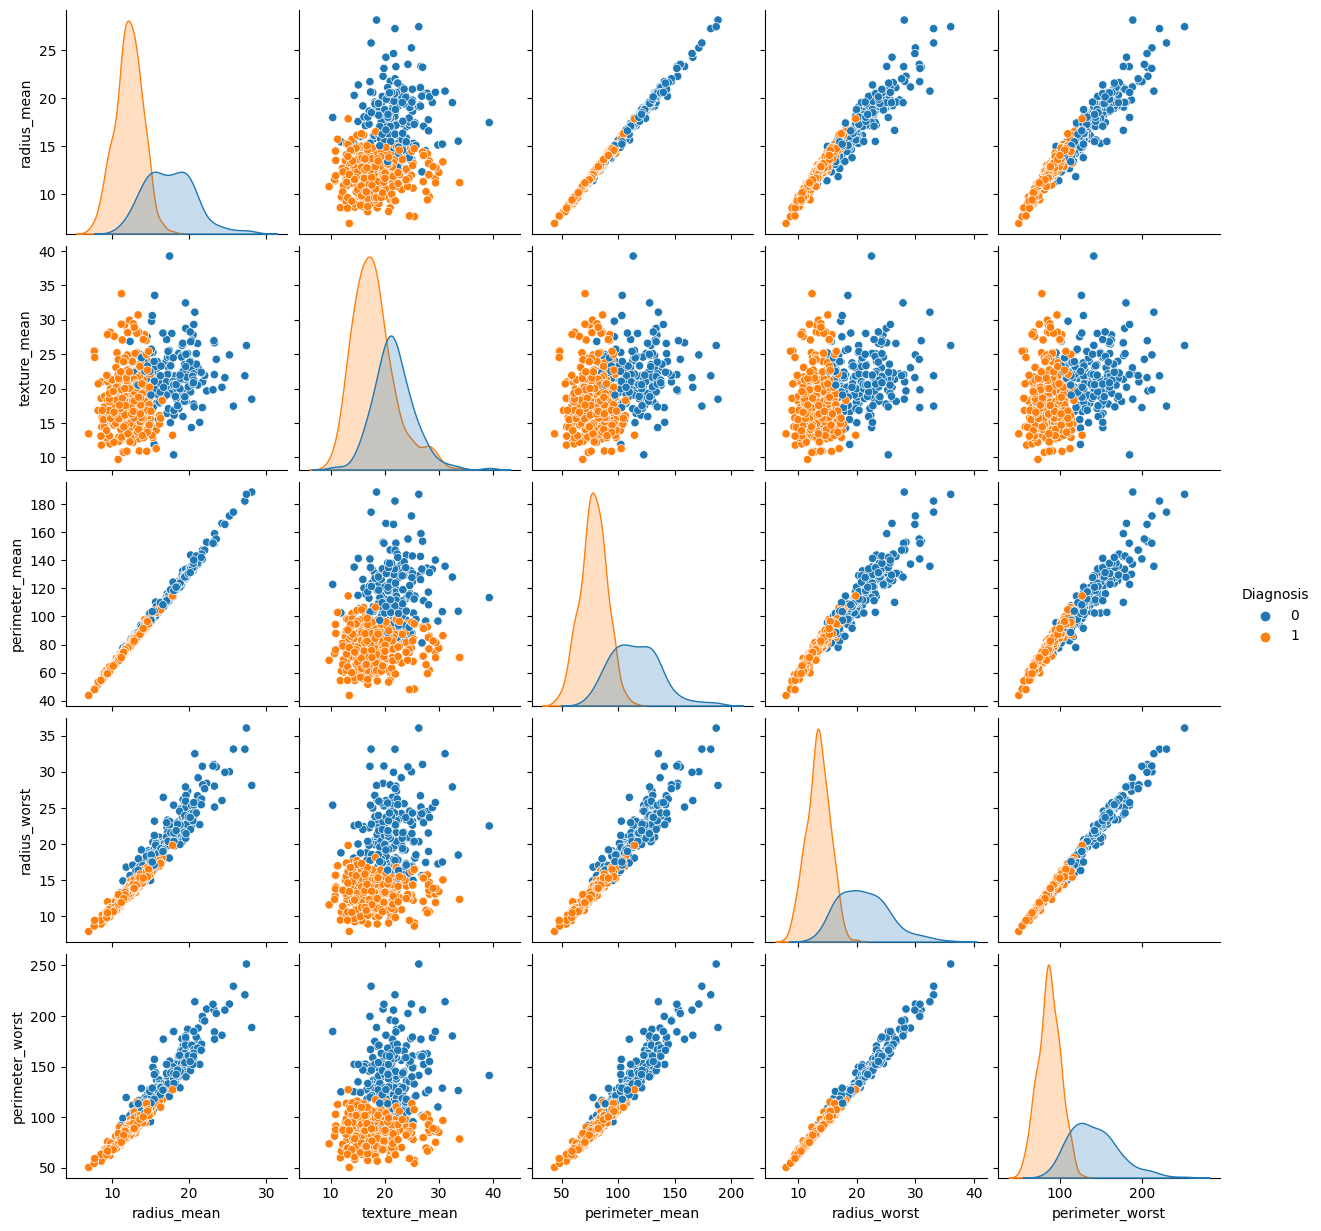

In [13]:
# pairplot
plt.figure(figsize=(15,15))
sns.pairplot(data, hue="Diagnosis", vars=["radius_mean", "texture_mean", "perimeter_mean", "radius_worst", "perimeter_worst"])
plt.show()

As expected by the correlation matrix, texture_mean is not correlated to the other variables, however there does seem to be a split in diagnoses, suggesting this feature may still hold predictive power.

# Correlation - put stuff about correlated variables/ experiments here!

# Data preparation

We split the data into a train and test set, fixing the random_state to ensure reproducibility.

In [14]:
# Train-test split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=4)

Checking that the X_train and y_train match up.

In [15]:
X_train.head()

,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave_points_mean,symmetry_mean,fractal_dimension_mean,...,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave_points_worst,symmetry_worst,fractal_dimension_worst
342,11.06,14.96,71.49,373.9,0.10330,0.09097,0.05397,0.03341,0.1776,0.06907,...,11.92,19.90,79.76,440.0,0.1418,0.2210,0.2299,0.10750,0.3301,0.09080
138,14.95,17.57,96.85,678.1,0.11670,0.13050,0.15390,0.08624,0.1957,0.06216,...,18.55,21.43,121.40,971.4,0.1411,0.2164,0.3355,0.16670,0.3414,0.07147
434,14.86,16.94,94.89,673.7,0.08924,0.07074,0.03346,0.02877,0.1573,0.05703,...,16.31,20.54,102.30,777.5,0.1218,0.1550,0.1220,0.07971,0.2525,0.06827
47,13.17,18.66,85.98,534.6,0.11580,0.12310,0.12260,0.07340,0.2128,0.06777,...,15.67,27.95,102.80,759.4,0.1786,0.4166,0.5006,0.20880,0.3900,0.11790
64,12.68,23.84,82.69,499.0,0.11220,0.12620,0.11280,0.06873,0.1905,0.06590,...,17.09,33.47,111.80,888.3,0.1851,0.4061,0.4024,0.17160,0.3383,0.10310


In [16]:
y_train.head()

,Diagnosis
342,1
138,0
434,1
47,0
64,0


Then, as discussed, we rescale the data to be normalised.

In [17]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Reproducibility
# Cross-validation grid search

# Useful functions

In [18]:
def calculations(y_test, pred_svc):
    [[TN, FP] , [FN, TP]] = confusion_matrix(y_test, pred_svc).tolist()
    P = TP + FN
    N = TN + FP
    return P, N, TN, FP, FN, TP

def matric_sensitivity(y_test, pred_svc):
    [P,_,_,_,_,TP] = calculations(y_test, pred_svc)
    return TP / P

def matric_specificity(y_test, pred_svc):
    [_,N,TN,_,_,_] = calculations(y_test, pred_svc)
    return TN / N

def matric_accuracy(y_test, pred_svc):
    [P,N,TN,_,_,TP] = calculations(y_test, pred_svc)
    return (TP + TN) / (P + N)

def performance(confusion_matrix):
    [[TN, FP] , [FN, TP]] = confusion_matrix.tolist()
    P = TP + FN
    N = TN + FP
    sens = TP / P
    spec = TN / N
    acc = (TP + TN) / (P + N)
    print(f"Accuracy = {acc}")
    print(f"Sensitivity = {sens}")
    print(f"Specificity = {spec}")
    return

# Analyse data for colinearity (Andre)

The fact that we have so many high correlation variables make us suspect multicolonearity. Multicollinearity among independent variables will result in less reliable statistical inferences and make it harder to interprate models.

If we look at correlation coefficients below 0.3 we see a lot of features.

In [19]:
corr = X.corr().iloc[0,][1:]
corr[corr < 0.3]

smoothness_mean            0.170581
symmetry_mean              0.147741
fractal_dimension_mean    -0.311631
texture_se                -0.097317
smoothness_se             -0.222600
compactness_se             0.206000
concavity_se               0.194204
symmetry_se               -0.104321
fractal_dimension_se      -0.042641
texture_worst              0.297008
smoothness_worst           0.119616
symmetry_worst             0.163953
fractal_dimension_worst    0.007066
Name: radius_mean, dtype: float64

We can in theory succesfully predict the target using many predictors with very low correlation. If predictors are not too correlated amongst themselves (avoiding duplication of information). Thus they will tend to add information to the regression even if they are individually adding only a small amount of information. With a sufficient number of (individually) weak predictors you can make a prediction of the response variable that is highly accurate. The overall accuracy is somewhat complicated --- in linear regression it depends on the full correlation matrix of the predictors and their individual correlations with the response variable (see according to https://arxiv.org/abs/2109.08519).

However we can see that leat correlation is happening in standard diviation features and lower bound features which won't be suffiecent amount of information to get sufficient peditions using "enhancement" phenomena. Hence we will briefly look at variance inflation factor (VIF) which can detect and measure the amount of collinearity to then remove some features.

VIF measures how much the variance of the estimated regression coefficients is inflated as compared to when the predictor variables are not linearly related.

A common heuristic is that a VIF of 1-5 indecates moderate correlation; 5-10 indecates highly correlation.

In [ ]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
def vif_calc(df):
  vif = [variance_inflation_factor(df.values, i) for i in range(len(df.columns))]
  return pd.DataFrame({'Predictors': df.columns, 'VIF': vif})

In [ ]:
vif_calc(df)

,Predictors,VIF
0,radius_mean,63955.019898
1,texture_mean,251.093672
2,perimeter_mean,58213.349861
3,area_mean,1320.282793
4,smoothness_mean,393.418392
5,compactness_mean,200.983909
6,concavity_mean,158.033586
7,concave_points_mean,155.053368
8,symmetry_mean,184.712502
9,fractal_dimension_mean,683.379907


We can see very high numbers on highly correlated values as expected in `perimeter` features with `radius` features. But all the variables show high dependece.

To further improve dataset let's remove certain features to see if that helps us to get more correct model.

To do this let us first isolate the variables of most interest to us (mean).

In [ ]:
dp = pd.concat([X.iloc[:, :10], y], axis=1)
vif_calc(dp)

,Predictors,VIF
0,radius_mean,27999.328290
1,texture_mean,25.379581
2,perimeter_mean,30133.227621
3,area_mean,158.096502
4,smoothness_mean,136.565757
5,compactness_mean,84.636856
6,concavity_mean,26.088800
7,concave_points_mean,56.366230
8,symmetry_mean,74.980446
9,fractal_dimension_mean,222.695987


Thus we have overall decreased VIF factor, but radius and perimeter are still have large dependece. It is enough to just drop `radius` or `perimeter` to significatly decrease VIF.

In [ ]:
vif_calc(dp.drop(['radius_mean'], axis=1))

,Predictors,VIF
0,texture_mean,25.372693
1,perimeter_mean,373.391395
2,area_mean,150.544876
3,smoothness_mean,134.389136
4,compactness_mean,38.900927
5,concavity_mean,25.017939
6,concave_points_mean,56.063664
7,symmetry_mean,74.677809
8,fractal_dimension_mean,209.513080
9,Diagnosis,7.566210


We can further improve this number by droping `perimeter` as we can see the correlation of `perimeter` with `area` and `fractal_dimension`

In [ ]:
vif_calc(dp.drop(['radius_mean', 'perimeter_mean'], axis=1))

,Predictors,VIF
0,texture_mean,23.331317
1,area_mean,19.677318
2,smoothness_mean,131.855746
3,compactness_mean,38.710264
4,concavity_mean,24.237530
5,concave_points_mean,55.978502
6,symmetry_mean,71.784016
7,fractal_dimension_mean,190.754709
8,Diagnosis,7.548528


Now let's drop `fractal_dimension`

In [ ]:
df_mean = dp.drop(['radius_mean', 'perimeter_mean', 'fractal_dimension_mean'], axis=1)
vif_calc(df_mean)

,Predictors,VIF
0,texture_mean,20.733695
1,area_mean,19.585736
2,smoothness_mean,72.110029
3,compactness_mean,34.075592
4,concavity_mean,23.084746
5,concave_points_mean,48.449881
6,symmetry_mean,63.690121
7,Diagnosis,6.509037


In [ ]:
to_drop = ['radius_mean', 'perimeter_mean', 'fractal_dimension_mean', 'radius_se',
           'perimeter_se', 'fractal_dimension_se', 'radius_worst', 'perimeter_worst',
           'fractal_dimension_worst']
df_optim = df.drop(to_drop, axis=1)
vif_calc(df_optim)

,Predictors,VIF
0,texture_mean,31.335729
1,area_mean,71.797268
2,smoothness_mean,107.730416
3,compactness_mean,98.499716
4,concavity_mean,131.659632
5,concave_points_mean,99.807934
6,symmetry_mean,80.577285
7,texture_se,11.189299
8,area_se,8.049016
9,smoothness_se,13.259495


Potentially we could drop these off: `'symmetry_worst', 'smoothness_worst', 'texture_worst', 'concave_points_worst'`

# Logistic Regression (Geraint)

*Perform basic logistic regression
*Investigate whether features with low correlation to the target feature can be ignored
*Apply L1 and L2 regularisation

Logistic regression is a supervised machine learning algorithm, used to estimate the parameters of the logistic model. The logistic model assumes that the log-odds of an outcome (of the target feature) is a linear combination of some independent variables (features), and the parameters we wish to estimate are the coefficients of this linear combination. To do this we use the log-likelihood function, with an optional regularisation term (such as L1 or L2) to prevent overfitting, and then find values of the parameters that maximise this function using numerical optimisation techniques. We will investigate the effectiveness of different regularisation techniques as well as

In [ ]:
#We create a logistic model with no regularisation, therefore must use 'lbfgs' solver
model0 = LogisticRegression(penalty='none', solver='lbfgs')

In [ ]:
#We fit the model with our training data, requires target feature to be changed to a 1d array
#Note we are warned about not using a penalty but we will investigate this later
y_train0 = np.ravel(y_train)
model0.fit(X_train_scaled,y_train0)

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1173: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(


LogisticRegression(penalty='none')

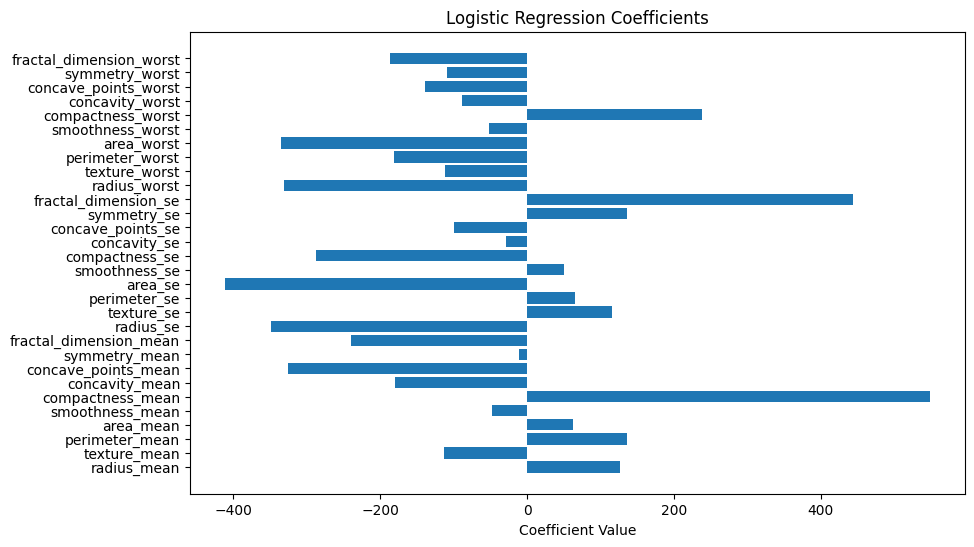

In [ ]:
#we can inspect the coefficients of the model and visualise them
coef0 = model0.coef_[0]
feature_names = X.columns.tolist()
plt.figure(figsize=(10, 6))
plt.barh(feature_names, coef0)
plt.xlabel('Coefficient Value')
plt.title('Logistic Regression Coefficients')
plt.show()

In [ ]:
#make predictions
predictions0 = model0.predict(X_test_scaled)

In [ ]:
#compare predictions with observed data using a confusion matrix
cm0 = confusion_matrix(y_test, predictions0)
print(cm0)

[[34  0]
 [ 6 74]]


In [ ]:
#now use the performance function to obtain the 3 main performance metrics
performance(cm0)

Accuracy = 0.9473684210526315
Sensitivity = 0.925
Specificity = 1.0


As expected we see a fairly poor performance, especially in terms of sensitivity, the metric we are aiming to optimise for.

In [ ]:
#We can investigate whether ignoring features with low correlation to the target feature could reduce noise and improve our model
threshold = 0.6
cor_target = abs(corr["Diagnosis"])
relevant_features = cor_target[cor_target>threshold]
names = relevant_features.keys()
#drop the target feature from the list of 'highly' correlated features
relevant_names = names.drop('Diagnosis')
print(names)

Index(['radius_mean', 'perimeter_mean', 'area_mean', 'concavity_mean',
       'concave_points_mean', 'radius_worst', 'perimeter_worst', 'area_worst',
       'concavity_worst', 'concave_points_worst', 'Diagnosis'],
      dtype='object')


In [ ]:
#Now create training data with only the highly correlated features
indices = np.where(abs(corr["Diagnosis"]) > threshold)[0]
X_train_scaled1, X_test_scaled1 = X_train_scaled[:, indices-1], X_test_scaled[:, indices-1]

In [ ]:
model1 = LogisticRegression(penalty='none', solver='lbfgs')

In [ ]:
model1.fit(X_train_scaled1, y_train0)

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1173: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(


LogisticRegression(penalty='none')

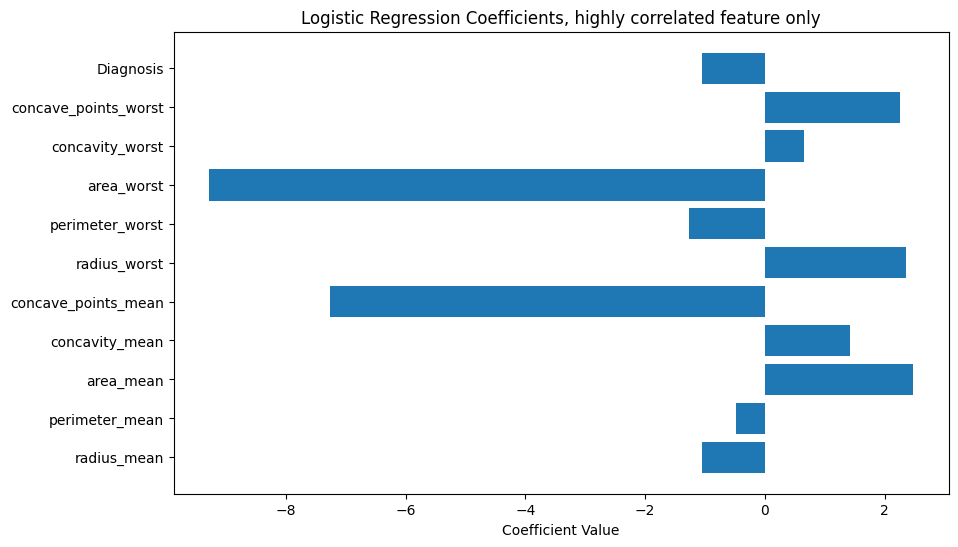

In [ ]:
coef1 = model1.coef_[0]
plt.figure(figsize=(10, 6))
plt.barh(names, coef1)
plt.xlabel('Coefficient Value')
plt.title('Logistic Regression Coefficients, highly correlated feature only')
plt.show()

In [ ]:
predictions1 = model1.predict(X_test_scaled1)

In [ ]:
cm1 = confusion_matrix(y_test, predictions1)
print(cm1)

[[34  0]
 [ 7 73]]


In [ ]:
performance(cm1)

Accuracy = 0.9385964912280702
Sensitivity = 0.9125
Specificity = 1.0


In [ ]:
#we can see whether scaling our data will improve our model
sc = StandardScaler()
X_train1_sc = sc.fit_transform(X_train1)
X_test1_sc = sc.fit_transform(X_test1)
#assert abs(X_train1_sc.mean()) < 1e10 , abs(1 - X_train1_sc.std()) < 1e10
#assert abs(X_test1_sc.mean()) < 1e10 , abs(1 - X_test1_sc.std()) < 1e10

In [ ]:
model_sc = LogisticRegression()
model_sc.fit(X_train1_sc, y_train1)

LogisticRegression()

In [ ]:
predictions_sc = model_sc.predict(X_test1_sc)

In [ ]:
cm_sc = confusion_matrix(y_test1, predictions_sc)
print(cm_sc)

[[34  0]
 [ 5 75]]


In [ ]:
performance(cm_sc)

Accuracy = 0.956140350877193
Sensitivity = 0.9375
Specificity = 1.0


# SVM (Andre)

A Support Vector Machine (SVM) determines the optimal hyperplane to divide classes. It is achieved by maximising the gap between the decision boundary and each class of points. For linear classfier of our two class data we can have infinite many decision boundaries between classes.

This algorithm is very efficienta as instead of looking at all the data points, SVM focuses on just a few key ones known as support vectors, which are the data points closest to the dividing line. These support vectors guide SVM in choosing the best possible dividing line.

To achieve this, we use an cost function. This function represents the gap between the data points and the dividing line. We strive to maximize this gap, which means we aim to minimize something called hinge loss. Hinge loss measures how far a point is from the dividing line when it's wrongly classified.

For our dataset of sample size 569 with 31 numeric predictors without encoding, Support Vector Machine (SVM) is fitting model because:
1. SVM is more effective in high dimensional spaces;
2. SVM are less likely to overfit to training data as less sensative to outliers than logistic regression;
2. SVM is less sensitive to multicollinbearity. In particular we will consider non-linear SVMs.:

As well as, all of the disadvantages are avoided as:
1. Dataset is not large;
2. Number of features for each data point doesn't exceed the number of training data samples ie SVM won't underpreform;
3. Data set is not too noisy and target classes are not overlapping.

In [ ]:
from sklearn.svm import SVC, LinearSVC

There's two different implmentations of linear svc `LinearSVC` and `SVC(kernel='linear')` which differ based on implementation (ie liblinear and libsvm respectively) [elaborate]

"The main differences between LinearSVC and SVC lie in the loss function used by default, and in the handling of intercept regularization between those two implementations." from documentation.

In [ ]:
lin_svc = LinearSVC()
grid_svc = GridSearchCV(lin_svc, {'C':[1, .1, .01, .001]}, cv=10) # GridSearchCV rely on an internal scoring strategy
grid_svc.fit(X_train_scaled, y_train.values.ravel())
print("Best C:", grid_svc.best_params_)
print("Best train score:", grid_svc.best_score_)

Best C: {'C': 0.01}
Best train score: 0.9801932367149758


Optimising for the best C parameter and the type of kernel [elaborate on kernels and hyperparam C]

In [ ]:
params_svc = {
    'C': [1, .1, .01, .001],
    'kernel': ['linear', 'poly', 'rbf']
}

Improve on scoring -> use metric we agreed

In [ ]:
from sklearn.metrics import make_scorer # may use
scoring = {
    "Accuracy": make_scorer(matric_accuracy),
    "Sensitivity": make_scorer(matric_sensitivity),
    "Specificity": make_scorer(matric_specificity),
}

In [ ]:
# make sure that I need this
lin_svc = LinearSVC()
grid_svc = GridSearchCV(lin_svc, {'C':[1, .1, .01, .001]}, cv=4, scoring='recall', return_train_score=True)
grid_svc.fit(X_train_scaled, y_train.values.ravel())
print("Best C:", grid_svc.best_params_)
print("Best train score:", grid_svc.best_score_)

Best C: {'C': 0.01}
Best train score: 0.9928053830227743


In [ ]:
def gridSearch(scoring, X_train_scaled):
  grid_svc = GridSearchCV(SVC(), params_svc, scoring=scoring, cv=15)
  grid_svc.fit(X_train_scaled, y_train.values.ravel())
  print("Best C:", grid_svc.best_params_)
  print("Best train score:", grid_svc.best_score_)
  cv_results = grid_svc.cv_results_

  scores_mean = np.array(cv_results['mean_test_score']).reshape(len(params_svc['kernel']),len(params_svc['C']))
  scores_sd = np.array(cv_results['std_test_score']).reshape(len(params_svc['kernel']),len(params_svc['C']))

  # Plot Grid search scores
  _, ax = plt.subplots(1,1)

  xaxis = np.log(params_svc['C']) # scale x-axis

  # Param1 is the X-axis, Param 2 is represented as a different curve (color line)
  for idx, val in enumerate(params_svc['kernel']):
      ax.plot(xaxis, scores_mean[idx,:], '-o', label= f'kernel {val}')

  plt.xticks(xaxis, params_svc['C'])
  ax.set_title("Grid Search Scores")
  ax.legend()
  plt.xlabel('Hyperparameter C')
  plt.ylabel(f'Score ({scoring})')
  ax.grid('on')
  # ax.set_ylim(.6,1)
  return grid_svc

Best C: {'C': 0.1, 'kernel': 'linear'}
Best train score: 0.9801433691756273


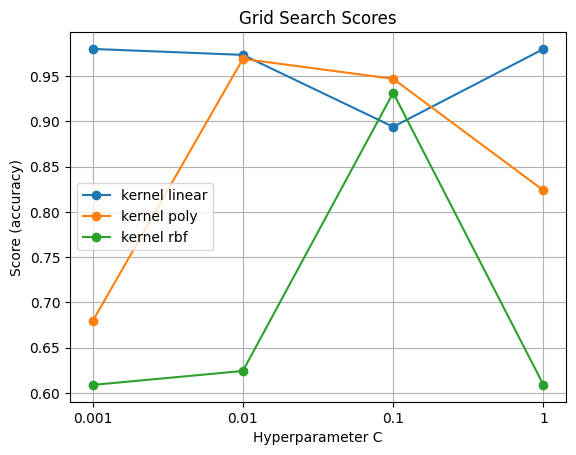

In [ ]:
grid_svc_acc = gridSearch('accuracy', X_train_scaled)

Best C: {'C': 1, 'kernel': 'poly'}
Best train score: 1.0


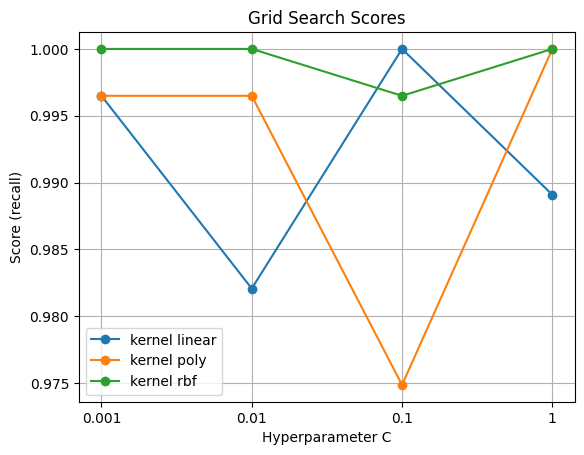

In [ ]:
grid_svc_recall = gridSearch('recall', X_train_scaled)

Best C: {'C': 1, 'kernel': 'linear'}
Best train score: 0.9794736842105264


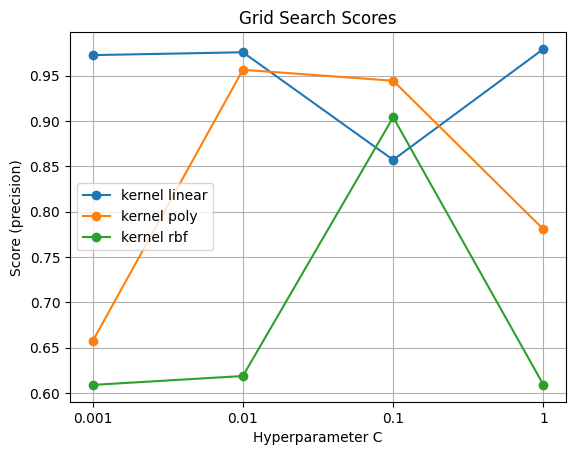

In [ ]:
grid_svc_precision = gridSearch('precision', X_train_scaled)

It's fine to use ROC since data is quite balanced.

Best C: {'C': 1, 'kernel': 'linear'}
Best train score: 0.9975308641975308


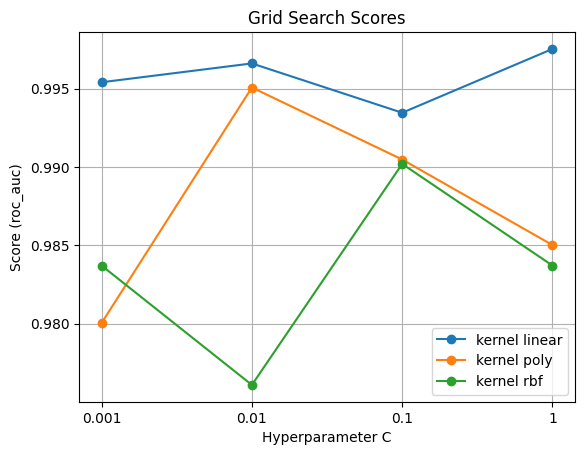

In [ ]:
grid_svc_ROC = gridSearch('roc_auc', X_train_scaled)

Scores

In [ ]:
models = [grid_svc_acc, grid_svc_precision, grid_svc_recall, grid_svc_ROC]

pd.DataFrame({
    'Model': [x.best_estimator_ for x in models],
    'Score': [x.best_score_ for x in models]})

,Model,Score
0,"SVC(C=0.1, kernel='linear')",0.980143
1,"SVC(C=1, kernel='linear')",0.979474
2,"SVC(C=1, kernel='poly')",1.000000
3,"SVC(C=1, kernel='linear')",0.997531


Discuss potential of overfitting.

In [ ]:
X_optim = df_optim.loc[:, df_optim.columns != 'Diagnosis']
y_optim = df_optim['Diagnosis']
X_optim_train, X_optim_test, y_optim_train, y_optim_test = train_test_split(X_optim, y_optim, test_size=0.2, random_state=4)
scaler_optim = StandardScaler()
X_optim_train_scaled = scaler_optim.fit_transform(X_optim_train)
X_optim_test_scaled = scaler_optim.transform(X_optim_test)

Best C: {'C': 1, 'kernel': 'linear'}
Best train score: 0.9735483870967742
Best C: {'C': 1, 'kernel': 'linear'}
Best train score: 0.9960201429499674


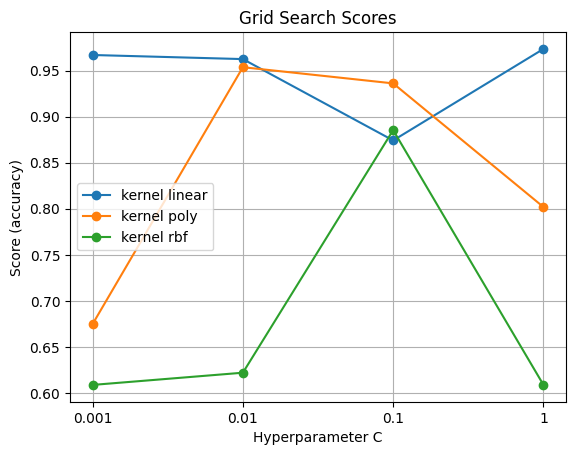

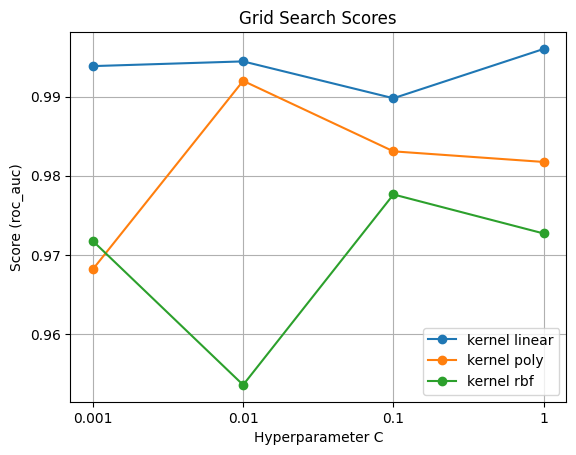

In [ ]:
grid_svc_acc = gridSearch('accuracy', X_optim_train_scaled)
grid_svc_roc = gridSearch('roc_auc', X_optim_train_scaled)

Idea for conclusion:

We have a most of our predictiors highly correlated with each other and a quoter of them have high correlation of >0.6. Which is expected as for instance readius is perfectly corrlated with pretimiter as expected.

We can into depths of showing this more rigourously with VIF.

But overall it makes it hard to interpret the model and also creates an overfitting problem.

We can lead in significance of weak predictors and attempt using less features for more accurate prediction.

#Josh

I would like to see if there are any features which show a high correlation to the Diagnonsis target variable. To do so we construct a correlation heatmap and select the diagnonsis column

In [20]:
corr = df.corr()
corr.style.background_gradient(cmap='coolwarm')

,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave_points_mean,symmetry_mean,fractal_dimension_mean,radius_se,texture_se,perimeter_se,area_se,smoothness_se,compactness_se,concavity_se,concave_points_se,symmetry_se,fractal_dimension_se,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave_points_worst,symmetry_worst,fractal_dimension_worst,Diagnosis
radius_mean,1.000000,0.323782,0.997855,0.987357,0.170581,0.506124,0.676764,0.822529,0.147741,-0.311631,0.679090,-0.097317,0.674172,0.735864,-0.222600,0.206000,0.194204,0.376169,-0.104321,-0.042641,0.969539,0.297008,0.965137,0.941082,0.119616,0.413463,0.526911,0.744214,0.163953,0.007066,-0.730029
texture_mean,0.323782,1.000000,0.329533,0.321086,-0.023389,0.236702,0.302418,0.293464,0.071401,-0.076437,0.275869,0.386358,0.281673,0.259845,0.006614,0.191975,0.143293,0.163851,0.009127,0.054458,0.352573,0.912045,0.358040,0.343546,0.077503,0.277830,0.301025,0.295316,0.105008,0.119205,-0.415185
perimeter_mean,0.997855,0.329533,1.000000,0.986507,0.207278,0.556936,0.716136,0.850977,0.183027,-0.261477,0.691765,-0.086761,0.693135,0.744983,-0.202694,0.250744,0.228082,0.407217,-0.081629,-0.005523,0.969476,0.303038,0.970387,0.941550,0.150549,0.455774,0.563879,0.771241,0.189115,0.051019,-0.742636
area_mean,0.987357,0.321086,0.986507,1.000000,0.177028,0.498502,0.685983,0.823269,0.151293,-0.283110,0.732562,-0.066280,0.726628,0.800086,-0.166777,0.212583,0.207660,0.372320,-0.072497,-0.019887,0.962746,0.287489,0.959120,0.959213,0.123523,0.390410,0.512606,0.722017,0.143570,0.003738,-0.708984
smoothness_mean,0.170581,-0.023389,0.207278,0.177028,1.000000,0.659123,0.521984,0.553695,0.557775,0.584792,0.301467,0.068406,0.296092,0.246552,0.332375,0.318943,0.248396,0.380676,0.200774,0.283607,0.213120,0.036072,0.238853,0.206718,0.805324,0.472468,0.434926,0.503053,0.394309,0.499316,-0.358560
compactness_mean,0.506124,0.236702,0.556936,0.498502,0.659123,1.000000,0.883121,0.831135,0.602641,0.565369,0.497473,0.046205,0.548905,0.455653,0.135299,0.738722,0.570517,0.642262,0.229977,0.507318,0.535315,0.248133,0.590210,0.509604,0.565541,0.865809,0.816275,0.815573,0.510223,0.687382,-0.596534
concavity_mean,0.676764,0.302418,0.716136,0.685983,0.521984,0.883121,1.000000,0.921391,0.500667,0.336783,0.631925,0.076218,0.660391,0.617427,0.098564,0.670279,0.691270,0.683260,0.178009,0.449301,0.688236,0.299879,0.729565,0.675987,0.448822,0.754968,0.884103,0.861323,0.409464,0.514930,-0.696360
concave_points_mean,0.822529,0.293464,0.850977,0.823269,0.553695,0.831135,0.921391,1.000000,0.462497,0.166917,0.698050,0.021480,0.710650,0.690299,0.027653,0.490424,0.439167,0.615634,0.095351,0.257584,0.830318,0.292752,0.855923,0.809630,0.452753,0.667454,0.752399,0.910155,0.375744,0.368661,-0.776614
symmetry_mean,0.147741,0.071401,0.183027,0.151293,0.557775,0.602641,0.500667,0.462497,1.000000,0.479921,0.303379,0.128053,0.313893,0.223970,0.187321,0.421659,0.342627,0.393298,0.449137,0.331786,0.185728,0.090651,0.219169,0.177193,0.426675,0.473200,0.433721,0.430297,0.699826,0.438413,-0.330499
fractal_dimension_mean,-0.311631,-0.076437,-0.261477,-0.283110,0.584792,0.565369,0.336783,0.166917,0.479921,1.000000,0.000111,0.164174,0.039830,-0.090170,0.401964,0.559837,0.446630,0.341198,0.345007,0.688132,-0.253691,-0.051269,-0.205151,-0.231854,0.504942,0.458798,0.346234,0.175325,0.334019,0.767297,0.012838


In [21]:
cor_target = abs(corr["Diagnosis"])
relevant_features = abs(corr["Diagnosis"]).sort_values(ascending=False).drop('Diagnosis')
print('A sorted list of the correlation between each variable and the target variable')
relevant_features

A sorted list of the correlation between each variable and the target variable


concave_points_worst       0.793566
perimeter_worst            0.782914
concave_points_mean        0.776614
radius_worst               0.776454
perimeter_mean             0.742636
area_worst                 0.733825
radius_mean                0.730029
area_mean                  0.708984
concavity_mean             0.696360
concavity_worst            0.659610
compactness_mean           0.596534
compactness_worst          0.590998
radius_se                  0.567134
perimeter_se               0.556141
area_se                    0.548236
texture_worst              0.456903
smoothness_worst           0.421465
symmetry_worst             0.416294
texture_mean               0.415185
concave_points_se          0.408042
smoothness_mean            0.358560
symmetry_mean              0.330499
fractal_dimension_worst    0.323872
compactness_se             0.292999
concavity_se               0.253730
fractal_dimension_se       0.077972
smoothness_se              0.067016
fractal_dimension_mean     0

We select all features with a high correlation to the target variable (>0.5).

In [22]:
ten_relevant_features = relevant_features[0:15]
names = ten_relevant_features.keys()
print('A sorted list of the variables with >0.5 correlation')
print(ten_relevant_features)

A sorted list of the variables with >0.5 correlation
concave_points_worst    0.793566
perimeter_worst         0.782914
concave_points_mean     0.776614
radius_worst            0.776454
perimeter_mean          0.742636
area_worst              0.733825
radius_mean             0.730029
area_mean               0.708984
concavity_mean          0.696360
concavity_worst         0.659610
compactness_mean        0.596534
compactness_worst       0.590998
radius_se               0.567134
perimeter_se            0.556141
area_se                 0.548236
Name: Diagnosis, dtype: float64


We would like to further remove variables with high correlation between themselves as we assume they contain similar information.

In [23]:
X_relevant = X[names]
corr2 = X_relevant.corr()
corr2.style.background_gradient(cmap='coolwarm')

,concave_points_worst,perimeter_worst,concave_points_mean,radius_worst,perimeter_mean,area_worst,radius_mean,area_mean,concavity_mean,concavity_worst,compactness_mean,compactness_worst,radius_se,perimeter_se,area_se
concave_points_worst,1.000000,0.816322,0.910155,0.787424,0.771241,0.747419,0.744214,0.722017,0.861323,0.855434,0.815573,0.801080,0.531062,0.554897,0.538166
perimeter_worst,0.816322,1.000000,0.855923,0.993708,0.970387,0.977578,0.965137,0.959120,0.729565,0.618344,0.590210,0.529408,0.719684,0.721031,0.761213
concave_points_mean,0.910155,0.855923,1.000000,0.830318,0.850977,0.809630,0.822529,0.823269,0.921391,0.752399,0.831135,0.667454,0.698050,0.710650,0.690299
radius_worst,0.787424,0.993708,0.830318,1.000000,0.969476,0.984015,0.969539,0.962746,0.688236,0.573975,0.535315,0.475820,0.715065,0.697201,0.757373
perimeter_mean,0.771241,0.970387,0.850977,0.969476,1.000000,0.941550,0.997855,0.986507,0.716136,0.563879,0.556936,0.455774,0.691765,0.693135,0.744983
area_worst,0.747419,0.977578,0.809630,0.984015,0.941550,1.000000,0.941082,0.959213,0.675987,0.543331,0.509604,0.438296,0.751548,0.730713,0.811408
radius_mean,0.744214,0.965137,0.822529,0.969539,0.997855,0.941082,1.000000,0.987357,0.676764,0.526911,0.506124,0.413463,0.679090,0.674172,0.735864
area_mean,0.722017,0.959120,0.823269,0.962746,0.986507,0.959213,0.987357,1.000000,0.685983,0.512606,0.498502,0.390410,0.732562,0.726628,0.800086
concavity_mean,0.861323,0.729565,0.921391,0.688236,0.716136,0.675987,0.676764,0.685983,1.000000,0.884103,0.883121,0.754968,0.631925,0.660391,0.617427
concavity_worst,0.855434,0.618344,0.752399,0.573975,0.563879,0.543331,0.526911,0.512606,0.884103,1.000000,0.816275,0.892261,0.380585,0.418899,0.385100


From the above heatmap, we decide to replace :



*   radius_worst, perimeter_mean, area_worst, radius_mean, area_mean with radius_worst
*   radius_se, perimeter_se, area_se with radius_se

We do this as they share high correlation with each other and radius_worst and radius_se have the best correlation with the target within these groups.

In [24]:
def performanceJ(confusion_matrix):
    [[TN, FP] , [FN, TP]] = confusion_matrix.tolist()
    P = TP + FN
    N = TN + FP
    sens = TP / P
    spec = TN / N
    acc = (TP + TN) / (P + N)
    accurancy =  str(acc)
    sensitivity =  str(sens)
    specificity =  str(spec)
    return accurancy, sensitivity,specificity

Above we introduce a performance calculator, we are looking to find the best sensitivity. We include accuracy and specificity for interest.

In [25]:
X_relevant_dropped = X_relevant.drop(columns=['perimeter_mean','area_worst','radius_mean','area_mean'])

Below we create 6 models. Basic decision trees and random forests with both scaled and uncscaled data, and a decision tree with optimal parameters.

In [27]:
def fix_seed():

  # Set seeds for reproducibility
  seed_value = 42

  # 1. Set the seed for Python's built-in random number generator
  random.seed(seed_value)

  # 2. Set the seed for NumPy
  np.random.seed(seed_value)

  # 3. Set the seed for PyTorch
  torch.manual_seed(seed_value)
  torch.cuda.manual_seed(seed_value)
  torch.cuda.manual_seed_all(seed_value)  # if using multiple GPUs
  torch.backends.cudnn.deterministic = True
  torch.backends.cudnn.benchmark = False

In [28]:
fix_seed()
from sklearn.tree import DecisionTreeClassifier
model = DecisionTreeClassifier()
model.fit(X_train, y_train)
predictions = model.predict(X_test)
cm = confusion_matrix(y_test, predictions)
print(cm)
perf_cm =performanceJ(cm)

[[34  0]
 [10 70]]


Above is the most basic Decision tree we can make. We will use this to swet a 'base-line' we hope to improve.

In [32]:
fix_seed()
model_sc = DecisionTreeClassifier()
model_sc.fit(X_train_scaled, y_train)
predictions_sc = model_sc.predict(X_test_scaled)
cm_sc = confusion_matrix(y_test, predictions_sc)
print(cm_sc)
perf_sc = performanceJ(cm_sc)

[[34  0]
 [10 70]]


A common technique for improving model performance is to scale the data. However this is not the case for decision trees as they are not sensitive to varience in the data. I hope to highlight decision trees lack of sensitivity to scaling data by including both scaled and unscaled data and comparing their predictive ability.

In [33]:
fix_seed()
model_rf = RandomForestClassifier()
model_rf.fit(X_train, y_train)
predictions_rf = model.predict(X_test)
cm_rf = confusion_matrix(y_test, predictions_rf)
print(cm_rf)
perf_rf = performanceJ(cm_rf)

<ipython-input-33-19233215aa06>:3: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model_rf.fit(X_train, y_train)


[[34  0]
 [10 70]]


Random forests can be used to increase performance of decision trees by attempting to solve the issue of overfitting.

In [34]:
fix_seed()
model_rf_scaled = RandomForestClassifier()
model_rf_scaled.fit(X_train_scaled, y_train)
predictions_rf_scaled = model.predict(X_test)
cm_rf_sc = confusion_matrix(y_test, predictions_rf_scaled)
print(cm_rf_sc)
perf_rf_sc = performanceJ(cm_rf_sc)

<ipython-input-34-784168c1489a>:3: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model_rf_scaled.fit(X_train_scaled, y_train)


[[34  0]
 [10 70]]


Above we again introduce the scaled data to show a lack of improvement.

We would now like to tune the hyperparameters of the decision tree and random forest model. To do this we introduce the GridSearchCV, which takes an input of the model itself and a dictionary of possible parameters. It then performs cross-validation on every possible combination of parameters given in the dictionary and stores the optimal values.

It should be noted that this method requires the creation of many many models. For example in the random forest parameter search there are $3\times4\times4\times2\times3\times3\times2$ = 1728 models to be made with a 5-fold cross-validation being done. This results in 8640 models being ran, which is obviously extremely computationly expensive. In fact even for our moderately small dataset, whith singular models running almost instantly, the random forest grid search takes almost 22 minuites.

For the decision tree we try all possible measures of fit in sklearn (gini,entropy,log_loss).

Max_features controls how much of the data is seen when performing splits, which can help with overfitting.

ccp_alpha is used to adjust the sensitivity of miniml cost-pruning.

max_depth is used to control the complexity of the model, limiting the depth can help prevent overfitting.

In [ ]:
par_dtc = {'criterion':['gini', 'entropy', 'log_loss'],
           'max_depth':[2,4,6,8],
           'min_samples_split':[2,4,6,8],
          'max_features': ['auto', 'sqrt', 'log2'],
          'ccp_alpha': [0.1, 0.01, 0.001]}
gcv_dtc = GridSearchCV(estimator=model_sc, param_grid=par_dtc, cv=5, verbose=1)
gcv_dtc.fit(X_train_scaled, y_train)

Fitting 5 folds for each of 432 candidates, totalling 2160 fits


/usr/local/lib/python3.10/dist-packages/sklearn/tree/_classes.py:269: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/tree/_classes.py:269: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/tree/_classes.py:269: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/tree/_classes.py:269: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(
/usr/local/lib/pytho

GridSearchCV(cv=5, estimator=DecisionTreeClassifier(),
             param_grid={'ccp_alpha': [0.1, 0.01, 0.001],
                         'criterion': ['gini', 'entropy', 'log_loss'],
                         'max_depth': [2, 4, 6, 8],
                         'max_features': ['auto', 'sqrt', 'log2'],
                         'min_samples_split': [2, 4, 6, 8]},
             verbose=1)

For the random forest model we again test all criterion along with a selection of ccp_alpha, max_features, max_depth and min_samples_split values.

We also add the min_samples_leaf field to test. This is because with min_samples_leaf=2 we would expect a smoothing effect of the resulting trees, this could cause models which combine together better.

We also would like to see if bootstrapping affects performance, so we add it to the parameter list.


# **Note: the below cell takes over twenty minutes to run, the calculated best parameters are used in the models below. **

In [ ]:
##Commented out as Grid search takes a long time to run. variables saved below in the model

#par_rtc = {'criterion':['gini', 'entropy', 'log_loss'],
 #          'max_depth':[2,4,6,8],
#           'min_samples_split':[2,4,6,8],
 #          'min_samples_leaf':[1,2],
 #         'max_features': ['auto', 'sqrt', 'log2'],
 ##         'ccp_alpha': [0.1, 0.01, 0.001],
 #          'bootstrap': [True,False]}
#gcv_rtc = GridSearchCV(estimator=model_rf_scaled, param_grid=par_rtc, cv=5, verbose=1)
#gcv_rtc.fit(X_train_scaled, y_train)

Fitting 5 folds for each of 1728 candidates, totalling 8640 fits


Streaming output truncated to the last 5000 lines.
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifie

GridSearchCV(cv=5, estimator=RandomForestClassifier(),
             param_grid={'bootstrap': [True, False],
                         'ccp_alpha': [0.1, 0.01, 0.001],
                         'criterion': ['gini', 'entropy', 'log_loss'],
                         'max_depth': [2, 4, 6, 8],
                         'max_features': ['auto', 'sqrt', 'log2'],
                         'min_samples_leaf': [1, 2],
                         'min_samples_split': [2, 4, 6, 8]},
             verbose=1)

We extract the best parameters below and fit an according model to each.

In [ ]:
##Commented out as Grid search takes a long time to run. variables saved below in the model
#randforestparam = gcv_rtc.best_params_
#print(randforestparam)

{'bootstrap': True, 'ccp_alpha': 0.001, 'criterion': 'log_loss', 'max_depth': 8, 'max_features': 'log2', 'min_samples_leaf': 2, 'min_samples_split': 2}


In [ ]:
##Commented out as Grid search takes a long time to run. variables saved below in the model
#dectreeparam = gcv_dtc.best_params_
#print(dectreeparam)

{'ccp_alpha': 0.01, 'criterion': 'log_loss', 'max_depth': 8, 'max_features': 'auto', 'min_samples_split': 4}


In [35]:
fix_seed()
rtc_new = RandomForestClassifier(ccp_alpha= 0.001,criterion= 'log_loss',max_depth= 8,max_features= 'log2',min_samples_split=2,min_samples_leaf=2,bootstrap=True)

In [36]:
fix_seed()
model_sc_dt = DecisionTreeClassifier(ccp_alpha=0.01,criterion='log_loss',max_depth= 8,max_features= 'auto',min_samples_split= 4)

In [37]:
fix_seed()
model_sc_dt.fit(X_train_scaled, y_train)
predictions_sc_dt = model_sc_dt.predict(X_test_scaled)
cm_sc_dt = confusion_matrix(y_test, predictions_sc_dt)
print(cm_sc_dt)
perf_sc_dt = performanceJ(cm_sc_dt)

[[33  1]
 [13 67]]


/usr/local/lib/python3.10/dist-packages/sklearn/tree/_classes.py:269: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(


In [38]:
fix_seed()
rtc_new.fit(X_train_scaled, y_train)
pred_rtc = rtc_new.predict(X_test_scaled)
cm_rtc = confusion_matrix(y_test, pred_rtc)
print(cm_rtc)
perf_rtc = performanceJ(cm_rtc)

<ipython-input-38-e0cfdeb86858>:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rtc_new.fit(X_train_scaled, y_train)


[[33  1]
 [ 6 74]]


In [39]:

performancedf = {'Model Type': ['Standard Tree', 'Scaled data Tree','Scaled data Tree best Param','Random Rorest','Random Forest Scaled','RandomForest best param'],
                 'Accurancy': [perf_cm[0],perf_sc[0],perf_sc_dt[0],perf_rf[0],perf_rf_sc[0],perf_rtc[0]],
                 'Sensitivity': [perf_cm[1],perf_sc[1],perf_sc_dt[1],perf_rf[1],perf_rf_sc[1],perf_rtc[1]],
                 'Specificity': [perf_cm[2],perf_sc[2],perf_sc_dt[2],perf_rf[2],perf_rf_sc[2],perf_rtc[2]]}
performancedf = pd.DataFrame(data=performancedf)
performancedf

,Model Type,Accurancy,Sensitivity,Specificity
0,Standard Tree,0.9122807017543859,0.875,1.0
1,Scaled data Tree,0.9122807017543859,0.875,1.0
2,Scaled data Tree best Param,0.8771929824561403,0.8375,0.9705882352941176
3,Random Rorest,0.9122807017543859,0.875,1.0
4,Random Forest Scaled,0.9122807017543859,0.875,1.0
5,RandomForest best param,0.9385964912280702,0.925,0.9705882352941176


As we hoped to show, the scaling of the data had no effect on the predictive capability for either the decision tree or the random forest.

Our hyperparameter search also managed to increase accuracy and sensitivity for the random forest, however this improvement still falls behind the other models.

It should be noted these results are not cross validated and are used instead to give an idea of how they perform. Below we perform cross validation to ascertain mean performance

We would also like to inspect the roc_auc_score. This measures the area underneath an roc curve, with 1 indicating perfect performance and 0.5 suggesting completely random guesses.

In [40]:
false_positive_rate1, true_positive_rate1, threshold1 = roc_curve(y_test, predictions)
print('roc_auc_score for Decision Tree: ', roc_auc_score(y_test, predictions))

false_positive_rate2, true_positive_rate2, threshold2 = roc_curve(y_test, predictions_sc)
print('roc_auc_score for Decision Tree with scaled data: ', roc_auc_score(y_test, predictions_sc))

false_positive_rate5, true_positive_rate5, threshold5 = roc_curve(y_test, predictions_sc_dt)
print('roc_auc_score for Decision Tree with parameters: ', roc_auc_score(y_test, predictions_sc_dt))

false_positive_rate3, true_positive_rate3, threshold3 = roc_curve(y_test, predictions_rf)
print('roc_auc_score for Random Forest: ', roc_auc_score(y_test, predictions_rf))

false_positive_rate6, true_positive_rate6, threshold6 = roc_curve(y_test, predictions_rf_scaled)
print('roc_auc_score for Random Forest with scaled data: ', roc_auc_score(y_test, predictions_rf_scaled))

false_positive_rate4, true_positive_rate4, threshold4 = roc_curve(y_test, pred_rtc)
print('roc_auc_score for Random Forest with parameters: ', roc_auc_score(y_test, pred_rtc))

roc_auc_score for Decision Tree:  0.9375
roc_auc_score for Decision Tree with scaled data:  0.9375
roc_auc_score for Decision Tree with parameters:  0.9040441176470588
roc_auc_score for Random Forest:  0.9375
roc_auc_score for Random Forest with scaled data:  0.9375
roc_auc_score for Random Forest with parameters:  0.9477941176470588


The roc_auc score in highest for the random forest with hyperparameters. This is to be expected as it is the most complex model.

Below We use a slightly modified version of Andre's function run_model. I change it to look at sensitivity as we are interested in health data.

In [45]:
def run_modelJ(model, X, y, n_splits=5, random_state=None):
    """
    Run a machine learning model with K-Fold cross-validation.

    Args:
        model: The machine learning model (e.g., LogisticRegression, RandomForestClassifier, etc.).
        X_data: The feature data.
        y_data: The target variable.
        n_splits (int): The number of cross-validation splits.
        random_state (int): Random seed for reproducibility.

    Returns:
        mean_sensitivity (float): Mean accuracy across all folds.
    """
    # Initialize the model
    ml_model = model

    # Initialize K-Fold cross-validator
    kf = KFold(n_splits=n_splits, shuffle=True, random_state=random_state)

    # Lists to store cross-validation results
    sensitivity = []
    accuracy = []
    specificity = []

    X_data = X
    y_data = y['Diagnosis']

    # Perform K-Fold cross-validation
    for train_idx, test_idx in kf.split(X_data):
        X_train, X_test = X_data.iloc[train_idx], X_data.iloc[test_idx]
        y_train, y_test = y_data.iloc[train_idx], y_data.iloc[test_idx]

        # Fit the model on the training data
        ml_model.fit(X_train, y_train)

        # Make predictions on the test data
        y_pred = ml_model.predict(X_test)

        # Calculate accuracy for this fold
        cf = confusion_matrix(y_test, y_pred)
        sens = performanceJ(cf)[1]
        sens = float(sens)
        sensitivity.append(sens)
        acc = performanceJ(cf)[0]
        acc = float(acc)
        accuracy.append(acc)
        spec = performanceJ(cf)[2]
        spec = float(spec)
        specificity.append(spec)

    # Calculate the mean accuracy across all folds
    mean_sensitivity = sum(sensitivity) / n_splits
    mean_acc = sum(accuracy) / n_splits
    mean_spec = sum(specificity) / n_splits

    print(f"Sensitivities: {sensitivity}")
    print(f"Mean Sensitivity: {mean_sensitivity}")

    return mean_acc,mean_sensitivity,mean_spec

In [46]:
print('Standard Decision Tree')
sens_DT=run_modelJ(model,X,y,random_state=42)
print('Standard Decision Tree with scaling')
sens_DT_SC=run_modelJ(model_sc,X,y,random_state=42)
print('Decision Tree with scaling and parameters')
sens_DT_HP=run_modelJ(model_sc_dt,X,y,5,random_state=42)
print('Random Forest')
sens_RF=run_modelJ(model_rf,X,y,5,random_state=42)
print('Random Forest with scaling')
sens_RF_SC=run_modelJ(model_rf_scaled,X,y,5,random_state=42)
print('Random Forest with scaling and parameters')
sens_RF_HP=run_modelJ(rtc_new,X,y,5,random_state=42)

Standard Decision Tree
Sensitivities: [0.9295774647887324, 0.9090909090909091, 0.9436619718309859, 0.9577464788732394, 0.9701492537313433]
Mean Sensitivity: 0.942045215663042
Standard Decision Tree with scaling
Sensitivities: [0.9577464788732394, 0.948051948051948, 0.9436619718309859, 0.9577464788732394, 0.9701492537313433]
Mean Sensitivity: 0.9554712262721512
Decision Tree with scaling and parameters


/usr/local/lib/python3.10/dist-packages/sklearn/tree/_classes.py:269: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/tree/_classes.py:269: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/tree/_classes.py:269: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/tree/_classes.py:269: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(
/usr/local/lib/pytho

Sensitivities: [0.9859154929577465, 0.987012987012987, 0.9436619718309859, 0.9436619718309859, 0.9552238805970149]
Mean Sensitivity: 0.963095260845944
Random Forest
Sensitivities: [0.9859154929577465, 0.987012987012987, 0.971830985915493, 0.9577464788732394, 0.9850746268656716]
Mean Sensitivity: 0.9775161143250275
Random Forest with scaling
Sensitivities: [0.9859154929577465, 0.987012987012987, 0.971830985915493, 0.9577464788732394, 0.9850746268656716]
Mean Sensitivity: 0.9775161143250275
Random Forest with scaling and parameters
Sensitivities: [0.9859154929577465, 0.974025974025974, 0.971830985915493, 0.971830985915493, 0.9701492537313433]
Mean Sensitivity: 0.9747505385092101


As can be seen from the above results. The grid search was able to find parameters that improved the decision tree. Scaling does not improve the models, but it should be noted that the predicitons were already good and improving these further would be difficult with the size data set available. However, 97.45% sensitivity is still a very good result.


Below we investigate the effect removing variables which were lowly correlated to the response variable and highly correlated to each other.

In [48]:
print('Standard Decision Tree with Dropped Features')
DDT=run_modelJ(model,X_relevant_dropped,y,random_state=42)
print('Standard Decision Tree with scaling with Dropped Features')
DDTSC=run_modelJ(model_sc,X_relevant_dropped,y,random_state=42)
print('Decision Tree with scaling and parameters with Dropped Features')
DDTHP=run_modelJ(model_sc_dt,X_relevant_dropped,y,5,random_state=42)
print('Random Forest with Dropped Features')
DRF=run_modelJ(model_rf,X_relevant_dropped,y,5,random_state=42)
print('Random Forest with scaling with Dropped Features')
DRFSC=run_modelJ(model_rf_scaled,X_relevant_dropped,y,5,random_state=42)
print('Random Forest with scaling and parameters with Dropped Features')
DRFHP=run_modelJ(rtc_new,X_relevant_dropped,y,5,random_state=42)

Standard Decision Tree with Dropped Features
Sensitivities: [0.971830985915493, 0.961038961038961, 0.8450704225352113, 0.9436619718309859, 0.9552238805970149]
Mean Sensitivity: 0.9353652443835333
Standard Decision Tree with scaling with Dropped Features
Sensitivities: [0.9577464788732394, 0.961038961038961, 0.8732394366197183, 0.9577464788732394, 0.9552238805970149]
Mean Sensitivity: 0.9409990472004346
Decision Tree with scaling and parameters with Dropped Features
Sensitivities: [0.9436619718309859, 0.961038961038961, 0.8450704225352113, 0.9436619718309859, 0.9850746268656716]
Mean Sensitivity: 0.9357015908203632
Random Forest with Dropped Features


/usr/local/lib/python3.10/dist-packages/sklearn/tree/_classes.py:269: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/tree/_classes.py:269: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/tree/_classes.py:269: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/tree/_classes.py:269: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(
/usr/local/lib/pytho

Sensitivities: [0.971830985915493, 0.974025974025974, 0.9436619718309859, 0.9436619718309859, 0.9701492537313433]
Mean Sensitivity: 0.9606660314669565
Random Forest with scaling with Dropped Features
Sensitivities: [0.971830985915493, 0.961038961038961, 0.9436619718309859, 0.9577464788732394, 0.9552238805970149]
Mean Sensitivity: 0.9579004556511389
Random Forest with scaling and parameters with Dropped Features
Sensitivities: [0.971830985915493, 0.974025974025974, 0.9577464788732394, 0.9295774647887324, 0.9701492537313433]
Mean Sensitivity: 0.9606660314669565


I would like to explore the performance of all the models with both the whole feature set and the reduced feature set.

In [50]:
performancedffdropped = {'Model Type with Dropped Data': ['Standard Tree', 'Scaled data Tree','Scaled data Tree best Param','Random Rorest','Random Forest Scaled','RandomForest best param'],
                 'Mean Accurancy': [DDT[0],DDTSC[0],DDTHP[0],DRF[0],DRFSC[0],DRFHP[0]],
                 'Mean Sensitivity': [DDT[1],DDTSC[1],DDTHP[1],DRF[1],DRFSC[1],DRFHP[1]],
                 'Mean Specificity': [DDT[2],DDTSC[2],DDTHP[2],DRF[2],DRFSC[2],DRFHP[2]]}
performancedffdropped = pd.DataFrame(data=performancedffdropped)
performancedffdropped

,Model Type with Dropped Data,Mean Accurancy,Mean Sensitivity,Mean Specificity
0,Standard Tree,0.912141,0.935365,0.872467
1,Scaled data Tree,0.915650,0.940999,0.872467
2,Scaled data Tree best Param,0.910356,0.935702,0.868275
3,Random Rorest,0.945505,0.960666,0.920184
4,Random Forest Scaled,0.940242,0.957900,0.909824
5,RandomForest best param,0.941997,0.960666,0.910128


In [53]:
performancedff = {'Model Type with all features': ['Standard Tree', 'Scaled data Tree','Scaled data Tree best Param','Random Rorest','Random Forest Scaled','RandomForest best param'],
                 'Mean Accurancy': [sens_DT[0],sens_DT_SC[0],sens_DT_HP[0],sens_RF[0],sens_RF_SC[0],sens_RF_HP[0]],
                 'Mean Sensitivity': [sens_DT[1],sens_DT_SC[1],sens_DT_HP[1],sens_RF[1],sens_RF_SC[1],sens_RF_HP[1]],
                 'Mean Specificity': [sens_DT[2],sens_DT_SC[2],sens_DT_HP[2],sens_RF[2],sens_RF_SC[2],sens_RF_HP[2]]}
performancedff = pd.DataFrame(data=performancedff)
performancedff

,Model Type with all features,Mean Accurancy,Mean Sensitivity,Mean Specificity
0,Standard Tree,0.931470,0.942045,0.914779
1,Scaled data Tree,0.938503,0.955471,0.909824
2,Scaled data Tree best Param,0.929669,0.963095,0.874279
3,Random Rorest,0.963096,0.977516,0.938936
4,Random Forest Scaled,0.961341,0.977516,0.934285
5,RandomForest best param,0.961326,0.974751,0.939691


It seems the data which had dropped features seems to perform on average slightly worse. This suggests to me that the data was overfitting very slightly and most data held at least a little value/ information regarding the target variable.

Despite the dropped variables being highly correlated with each other and lowly correlated with the traget variable, there was still some information to be gained by adding them in.

However, the model still performs with a sensitivity only a few percent lower for all models. This is remarkable considering over half of the features were dropped. This does sugest the highly correlated variables shared alot of the information.

The Random forest performs the best, however our parameter search managed to reduce performance on average, this suggests that the hyperparemeters had underfit to the data, possibly due to the size of the dataset.

# Neural Networks (Ethan)



*   Do 4 or 5 fold cross-val for hyperparameter optimisation of neural networks
*   Hyperparameters include
  * Model architecture - number of layers and number of hidden units
  * Use of dropout or not
  * Use of batch norm or other normalisation techniques
  * Different activation functions
  * Optimizer and with/without weight decay
  * Loss function used
  * Regularization

* From cross-val, select best parameters for different reasons, retrain on entire training data and hopefully get conducive results, if not will be down to stochasiticity of small dataset

Due to 114 test samples, only a fixed number of possible output test accuracies which is why we see exact same accuracies reported

Potential conclusion: dataset relatively simple in context of what NNs are used for, so not much need for bigger architectures or extra features to push performance. NNs really for larger more complex data

https://gist.github.com/Guitaricet/28fbb2a753b1bb888ef0b2731c03c031

In [ ]:
def fix_seed():

  # Set seeds for reproducibility
  seed_value = 42

  # 1. Set the seed for Python's built-in random number generator
  random.seed(seed_value)

  # 2. Set the seed for NumPy
  np.random.seed(seed_value)

  # 3. Set the seed for PyTorch
  torch.manual_seed(seed_value)
  torch.cuda.manual_seed(seed_value)
  torch.cuda.manual_seed_all(seed_value)  # if using multiple GPUs
  torch.backends.cudnn.deterministic = True
  torch.backends.cudnn.benchmark = False

First we will convert the data to PyTorch tensors so that we can train neural networks on them in PyTorch.

In [ ]:
X_train_tensor = torch.tensor(X_train_scaled, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test_scaled, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.float32)

Next we define a simple feed-forward neural network model, that takes in a list of hidden units and the length of the list is the number of hidden layers. The input layers are 30 as the data is 30-dimensional and the output layer is 2 as it is a binary classifier.

In [ ]:
# Define your neural network model
class SimpleNN(nn.Module):
    def __init__(self, hidden_sizes):
        super(SimpleNN, self).__init__()
        self.layers = []
        prev_layer_size = 30
        for h in hidden_sizes:
            self.layers.append(nn.Linear(prev_layer_size, h))
            self.layers.append(nn.ReLU())
            prev_layer_size = h
        self.layers.append(nn.Linear(prev_layer_size, 1))
        self.model = nn.Sequential(*self.layers)

    def forward(self, x):
        return torch.sigmoid(self.model(x))

In [ ]:
fix_seed()
kf = KFold(n_splits=5, shuffle=True, random_state=42)
for train_index, val_index in kf.split(X_train_tensor):

  X_train_cv, X_val_cv = X_train_tensor[train_index], X_train_tensor[val_index]
  y_train_cv, y_val_cv = y_train_tensor[train_index], y_train_tensor[val_index]

  model = SimpleNN([4])

  criterion = nn.BCELoss()
  optimizer = optim.Adam(model.parameters(), lr=0.001)

  best_sensitivity = 0
  best_epoch = 0

  for epoch in range(500):
    model.train()
    optimizer.zero_grad()

    output = model(X_train_cv)
    loss = criterion(output, y_train_cv.view(-1,1))

    loss.backward()
    optimizer.step()

    with torch.no_grad():
      val_output = model(X_val_cv)
      val_loss = criterion(val_output, y_val_cv.view(-1, 1))
      predicted_labels = (val_output > 0.5).float()
      # val_acc = (predicted_labels == y_val_cv.view(-1, 1)).float().mean()
      # if val_acc >= best_sensitivity:
      #   best_sensitivity = val_acc
      #   best_epoch = epoch
      sensitivity = calculate_sensitivity(y_val_cv, predicted_labels)
      if sensitivity > best_sensitivity:
        best_sensitivity = sensitivity
        best_epoch = epoch

  print(best_sensitivity, best_epoch)
  print(sensitivity, epoch)

NameError: ignored

Trying to tune epochs as a hyperparameter does not really work, as we find that it is highly dependent on the specific data split - one such split may get very lucky in producing quicker convergence, this does not tell us much about how a different split may behave. So let us train for a fixed number of epochs going forward, say 500, and investigate different changes to the model.

In [ ]:
num_layers = [2, 3, 5]
hidden_sizes_lists = [[4]*n for n in num_layers]

In [ ]:
for n, hidden_sizes in zip(num_layers, hidden_sizes_lists):
  print(n, hidden_sizes)
  fix_seed()
  kf = KFold(n_splits=5, shuffle=True, random_state=42)
  for train_index, val_index in kf.split(X_train_tensor):

    X_train_cv, X_val_cv = X_train_tensor[train_index], X_train_tensor[val_index]
    y_train_cv, y_val_cv = y_train_tensor[train_index], y_train_tensor[val_index]

    model = SimpleNN(n, hidden_sizes)

    criterion = nn.BCELoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    best_sensitivity = 0
    best_epoch = 0

    for epoch in range(500):
      model.train()
      optimizer.zero_grad()

      output = model(X_train_cv)
      loss = criterion(output, y_train_cv.view(-1,1))

      loss.backward()
      optimizer.step()

    with torch.no_grad():
      val_output = model(X_val_cv)
      val_loss = criterion(val_output, y_val_cv.view(-1, 1))
      predicted_labels = (val_output > 0.5).float()
      # val_acc = (predicted_labels == y_val_cv.view(-1, 1)).float().mean()
      # if val_acc >= best_sensitivity:
      #   best_sensitivity = val_acc
      #   best_epoch = epoch
      sensitivity = calculate_sensitivity(y_val_cv, predicted_labels)
      if sensitivity > best_sensitivity:
        best_sensitivity = sensitivity
        best_epoch = epoch

    print(best_sensitivity, best_epoch)
    #print(sensitivity, epoch)

In [ ]:
type(y_train)

In [ ]:
i=4
plt.imshow(X_train_tensor[i].reshape((3,10)))
print(y_train_tensor[i])

In [ ]:
import torch
import random
import numpy as np



In [ ]:
fix_seed()

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        h = 32
        self.fc1 = nn.Linear(X_train.shape[1], h)
        self.fc2 = nn.Linear(h, 1)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = torch.sigmoid(self.fc2(x))
        return x

# Initialize the model
model = Net()

# Define the loss function and optimizer
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training the model
epochs = 350
for epoch in range(epochs):
    model.train()
    optimizer.zero_grad()
    output = model(X_train_tensor)
    loss = criterion(output, y_train_tensor.view(-1, 1))
    loss.backward()
    optimizer.step()

# Evaluate the model on the test data
model.eval()
with torch.no_grad():
    test_output = model(X_test_tensor)
    test_loss = criterion(test_output, y_test_tensor.view(-1, 1))
    predicted_labels = (test_output > 0.5).float()
    test_acc = (predicted_labels == y_test_tensor.view(-1, 1)).float().mean()

print(f'Test accuracy: {test_acc.item()}')

In [ ]:
108/114

In [ ]:
y_test_tensor.shape

In [ ]:
fix_seed()

# Define the neural network model with dropout
class NetWithDropout(nn.Module):
    def __init__(self):
        super(NetWithDropout, self).__init__()
        self.fc1 = nn.Linear(X_train.shape[1], 32)
        self.dropout = nn.Dropout(0)  # Adjust dropout rate as needed
        self.fc2 = nn.Linear(32, 1)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = self.dropout(x)  # Apply dropout
        x = torch.sigmoid(self.fc2(x))
        return x

# Initialize the model
model_with_dropout = NetWithDropout()

# Define the loss function and optimizer
criterion = nn.BCELoss()
optimizer = optim.Adam(model_with_dropout.parameters(), lr=0.001)

# Training the model with dropout
epochs = 100
for epoch in range(epochs):
    model_with_dropout.train()
    optimizer.zero_grad()
    output = model_with_dropout(X_train_tensor)
    loss = criterion(output, y_train_tensor.view(-1, 1))
    loss.backward()
    optimizer.step()

# Evaluate the model with dropout on the test data
model_with_dropout.eval()
with torch.no_grad():
    test_output = model_with_dropout(X_test_tensor)
    test_loss = criterion(test_output, y_test_tensor.view(-1, 1))
    predicted_labels = (test_output > 0.5).float()
    test_acc = (predicted_labels == y_test_tensor.view(-1, 1)).float().mean()

print(f'Test accuracy with dropout: {test_acc.item()}')

In [ ]:
fix_seed()

# Define the neural network model with dropout and batch normalization
class NetWithDropoutBN(nn.Module):
    def __init__(self):
        super(NetWithDropoutBN, self).__init__()
        self.fc1 = nn.Linear(X_train.shape[1], 32)
        self.bn1 = nn.BatchNorm1d(32)  # Batch normalization after the first fully connected layer
        #self.dropout = nn.Dropout(0.5)  # Adjust dropout rate as needed
        self.fc2 = nn.Linear(32, 1)

    def forward(self, x):
        x = F.relu(self.bn1(self.fc1(x)))  # Apply batch normalization before activation
        #x = self.dropout(x)  # Apply dropout
        x = torch.sigmoid(self.fc2(x))
        return x

# Initialize the model with dropout and batch normalization
model_with_dropout_bn = NetWithDropoutBN()

# Define the loss function and optimizer
criterion = nn.BCELoss()
optimizer = optim.Adam(model_with_dropout_bn.parameters(), lr=0.001)

# Training the model with dropout and batch normalization
epochs = 100
for epoch in range(epochs):
    model_with_dropout_bn.train()
    optimizer.zero_grad()
    output = model_with_dropout_bn(X_train_tensor)
    loss = criterion(output, y_train_tensor.view(-1, 1))
    loss.backward()
    optimizer.step()

# Evaluate the model with dropout and batch normalization on the test data
model_with_dropout_bn.eval()
with torch.no_grad():
    test_output = model_with_dropout_bn(X_test_tensor)
    test_loss = criterion(test_output, y_test_tensor.view(-1, 1))
    predicted_labels = (test_output > 0.5).float()
    test_acc = (predicted_labels == y_test_tensor.view(-1, 1)).float().mean()

print(f'Test accuracy with dropout and batch normalization: {test_acc.item()}')

In [ ]:
fix_seed()

# Define the neural network model with more layers
class NetWithMoreLayers(nn.Module):
    def __init__(self):
        super(NetWithMoreLayers, self).__init__()
        self.fc1 = nn.Linear(X_train.shape[1], 64)
        self.fc2 = nn.Linear(64, 32)
        self.fc3 = nn.Linear(32, 16)
        self.fc4 = nn.Linear(16, 1)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = torch.sigmoid(self.fc4(x))
        return x

# Initialize the model with more layers
model_with_more_layers = NetWithMoreLayers()

# Define the loss function and optimizer
criterion = nn.BCELoss()
optimizer = optim.Adam(model_with_more_layers.parameters(), lr=0.001)

# Training the model with more layers
epochs = 500
for epoch in range(epochs):
    model_with_more_layers.train()
    optimizer.zero_grad()
    output = model_with_more_layers(X_train_tensor)
    loss = criterion(output, y_train_tensor.view(-1, 1))
    loss.backward()
    optimizer.step()


model_with_more_layers.eval()
with torch.no_grad():
    test_output = model_with_more_layers(X_test_tensor)
    test_loss = criterion(test_output, y_test_tensor.view(-1, 1))
    predicted_labels = (test_output > 0.5).float()
    test_acc = (predicted_labels == y_test_tensor.view(-1, 1)).float().mean()

print(f'Test accuracy with more layers: {test_acc.item()}')

In [ ]:
fix_seed()

# Define the neural network model with more layers and L2 regularization
class NetWithRegularization(nn.Module):
    def __init__(self):
        super(NetWithRegularization, self).__init__()
        self.fc1 = nn.Linear(X_train.shape[1], 64)
        self.fc2 = nn.Linear(64, 32)
        self.fc3 = nn.Linear(32, 16)
        self.fc4 = nn.Linear(16, 1)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = torch.sigmoid(self.fc4(x))
        return x

# Initialize the model with L2 regularization
model_with_regularization = NetWithRegularization()

# Define the loss function and optimizer with L2 regularization
criterion = nn.BCELoss()
optimizer = optim.Adam(model_with_regularization.parameters(), lr=0.001)  # Adjust weight decay as needed

# Training the model with L2 regularization
epochs = 300
for epoch in range(epochs):
    model_with_regularization.train()
    optimizer.zero_grad()
    output = model_with_regularization(X_train_tensor)
    loss = criterion(output, y_train_tensor.view(-1, 1))

    # Add L2 regularization to the loss
    l2_lambda = 0.01  # Adjust the regularization strength
    l2_reg = torch.tensor(0.)
    for param in model_with_regularization.parameters():
        l2_reg += torch.norm(param)
    loss += l2_lambda * l2_reg

    loss.backward()
    optimizer.step()

# Evaluate the model with L2 regularization on the test data
model_with_regularization.eval()
with torch.no_grad():
    test_output = model_with_regularization(X_test_tensor)
    test_loss = criterion(test_output, y_test_tensor.view(-1, 1))
    predicted_labels = (test_output > 0.5).float()
    test_acc = (predicted_labels == y_test_tensor.view(-1, 1)).float().mean()

print(f'Test accuracy with L2 regularization: {test_acc.item()}')

# Conclusion